Introduction to Markov modelling with pyEMMA - TPT
=====

<pre> 
Antonia Mey                antonia.mey@fu-berlin.de  
Guillermo Perez-Hernandez  guille.perez@fu-berlin.de 
Frank Noe                  frank.noe@fu-berlin.de   

Modified for starting from discrete trajectories
</pre>

Imports:

In [1]:
import os
import numpy as np
import pyemma.coordinates as coor
import pyemma.msm as msm
import shortcuts
%pylab inline
import pyemma.plots as mpl

Populating the interactive namespace from numpy and matplotlib


Commands that would be needed to generate the initial data (not used here):

In [2]:
#trajfile = 'data/bpti_ca_1ms_dt10ns.xtc'
#topfile = 'data/bpti_ca.pdb'
# featurizer
#feat = coor.featurizer(topfile)
#feat.add_all()
# input
#inp = coor.source(trajfile, feat)
# tica + projection
#tica_obj = coor.tica(inp, lag=100, dim=2)
#Y = tica_obj.get_output()[0]
# clustering
#cl = coor.cluster_kmeans(data=Y, k=100, stride=10)
# for later use we save the discrete trajectories and cluster center coordinates:
#dtrajs = cl.dtrajs

Load discrete trajectories, clustercenters and histogram
------
Here we directly start by loading the discrete trajectories, clustercenters and the data histogram. Then we build a Markov state model for model as in the estimate-part:

In [3]:
#load discrete trajectories
indir = 'data/'
infiles = [os.path.join(indir, filename) for filename in os.listdir(indir)];
dtrajs = []
for filename in infiles:
    if filename.endswith('.dtraj'):
        dtraj = msm.io.read_dtraj(filename)
        dtrajs.append(dtraj)
#load clustercenters
clustercenters = np.loadtxt(indir+'BPTI-clustercenters.dat')
cc_x = clustercenters[:,0]
cc_y = clustercenters[:,1]
# load histogram
histogram_xy = np.loadtxt(indir+'BPTI-histogram_xy.dat')
z = np.loadtxt(indir+'BPTI-histogram_z.dat')
x = histogram_xy[0]
y = histogram_xy[1]
F = -np.log(z)
extent = [x[0], x[-1], y[0], y[-1]]
M = msm.estimate_markov_model(dtraj, 100)

/storage/mi/nplattner/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


Transition pathways and Committors
---------------

Finally, let us compute transition pathways between two selected endstates. This is a very nice mechanistic analysis that is often revealing when we have a two-state process between such as folding or binding. In the present case we would like to know which pathways does the system take to partially unfold into the rarely populated 'right' state. 

At first we have to select what the two end-states of our interest are. We have done PCCA which gives us an idea of metastable sets, but if we do a transition path analysis with three states that's a bit boring, because there are only two options: the single intermediate state is on-pathway or off-pathway. 

We want to get a more detailed analysis. Therefore we reconsider PCCA an this time ask for six metastable sets:

In [4]:
# do pcca with 6 states now
M.pcca(6)
pcca_sets_6 = M.metastable_sets

Which are assigned to the TICA plot as follows:

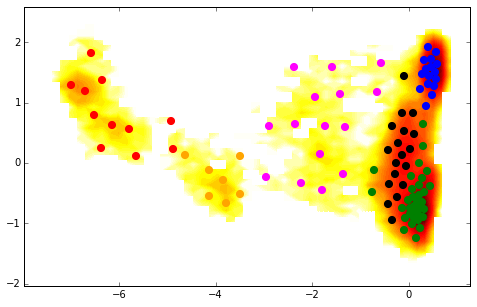

In [5]:
figure(figsize=(8,5))
pcca_sets = M.metastable_sets
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
size = 50
cols = ['orange', 'magenta', 'red', 'black', 'blue', 'green',]
for i in range(6):
    scatter(cc_x[pcca_sets_6[i]], cc_y[pcca_sets_6[i]], color=cols[i], s=size)

Now we select as two end-states the leftmost and the rightmost of these 6 sets. Since the ordering of metastable sets could differ in different runs, we actually compute their average positions along the first TICA coordinate:

In [6]:
xavg = shortcuts.avg_by_set(cc_x, pcca_sets_6)
A = pcca_sets_6[xavg.argmax()]
B = pcca_sets_6[xavg.argmin()]

Now we compute the transition pathways. This is done by discrete transition path theory [5] in its MSM formulation [6].

In [7]:
fluxAB = msm.tpt(M, A, B)

In [8]:
# mean first passage times in microseconds
print 0.01*M.mfpt(A, B)
print 0.01*M.mfpt(B, A)

1566.72616791
107.824149902


so, it takes about 1.5 milliseconds on average to go into the low-populated "open" state, and about
100 microseconds to switch back.

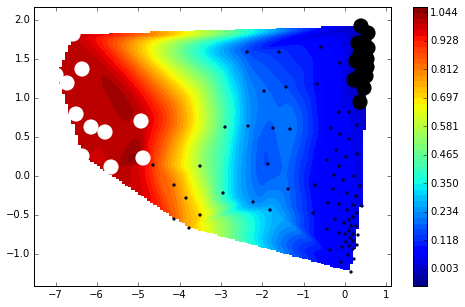

In [9]:
figure(figsize=(8,5))
mpl.scatter_contour(clustercenters[:,0], clustercenters[:,1], fluxAB.committor, colorbar=True, ncontours=15)
scatter(clustercenters[A,0], clustercenters[A,1], color='black', s=200)
scatter(clustercenters[B,0], clustercenters[B,1], color='white', s=200)

In [10]:
cg, cgflux = fluxAB.coarse_grain(pcca_sets)

In [11]:
# compute mean positions of sets. This is important because of some technical points the set order 
# in the coarse-grained TPT object can be different from the input order.
avgpos = np.zeros((6,2))
avgpos[:,0] = shortcuts.avg_by_set(cc_x, cg)
avgpos[:,1] = shortcuts.avg_by_set(cc_y, cg)

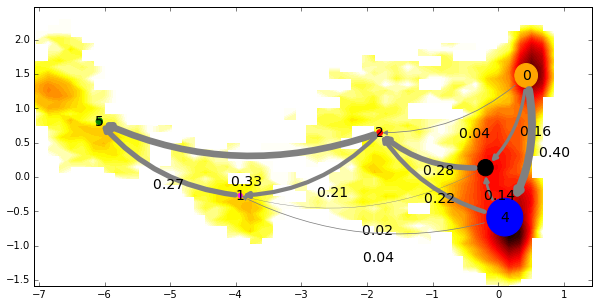

In [12]:
figure(figsize=(10,5))
contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
shortcuts.plot_network(1000.0*cgflux.net_flux, avgpos, cgflux.stationary_distribution, 
                       statecolors=cols, arrowscale=20.0, figscale=1.5, arrowlabel_format="%10.2f")

This shows us the probability fluxes of pathways from the rightmost state to the leftmost (rare-event) state. You can see that the main pathway leads us to the most stable state, that then splits into two pathways that merge in an intermediate, and then split again before uniting in the target state.

Let's play
-----
Check out the documentation of the reactive flux object:

    http://www.pythonhosted.org/pyEMMA/api/generated/pyemma.msm.flux.ReactiveFlux.html

1. Compute the flux into individual pathways, along with their fluxes (you'll need to call *pathways* with a fraction smaller than 1 - otherwise you'll get an error, which is currently being fixed). Normalize the fluxes to 1 or to 100 (percentages). What is the strongest pathway and how much flux is carried by it? How many pathways do you need for 90% of the flux?
2. Compute the major flux that is brought about by two pathways. Visualize it in the same way as the full flux above    

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
3. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
4. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
5. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
6. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)